<a href="https://colab.research.google.com/github/M-Arashi/SASA-DS/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


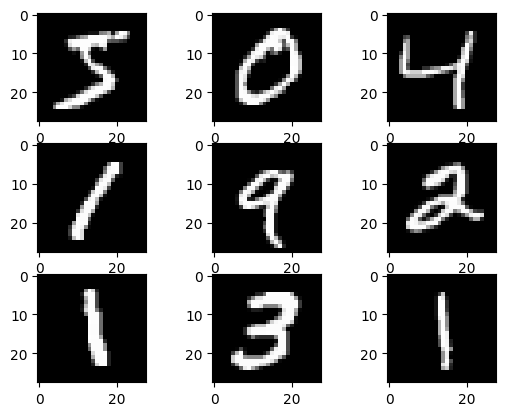

In [9]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

We know some things about the dataset.

For example, we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale.

Therefore, we can load the images and reshape the data arrays to have a single color channel.

In [10]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

We also know that there are 10 classes and that classes are represented as unique integers.

We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function.

In [11]:
# one hot encode target values
from tensorflow.keras.utils import to_categorical # Import the to_categorical function
trainY = to_categorical(trainY)
testY = to_categorical(testY)

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value

In [12]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# Define Model

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

In [13]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# Evaluate Model


In [14]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# Results

In [15]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [16]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

## Complete Example

In [17]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

> 98.675
> 98.600
> 98.642
> 98.775
> 98.717


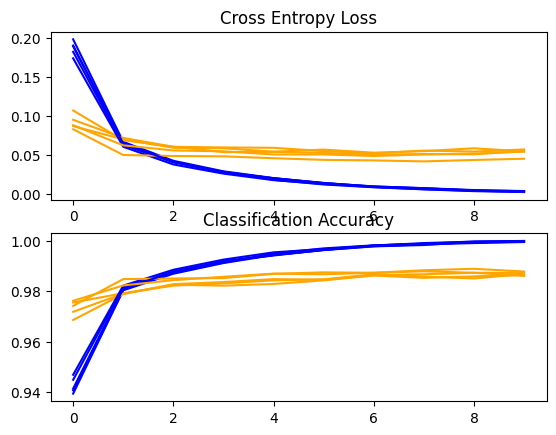

Accuracy: mean=98.682 std=0.060, n=5


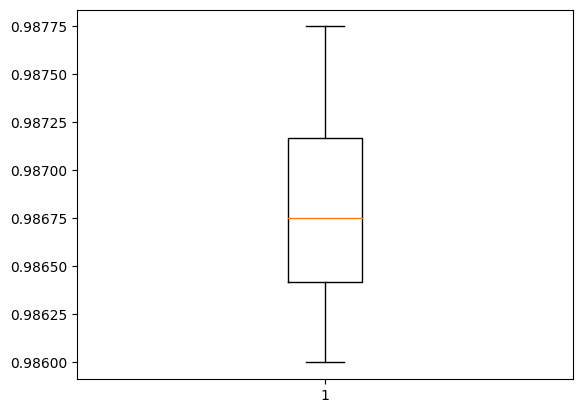

In [18]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()